<div>
<img src="logo.png" width=150 ALIGN="left" style='margin-right:10px; border-style: solid; border-width: 2px;' alt='logo'>
<h1>Starting Kit - MEDI-FAIR</h1>
<p>
This starting kit provides a brief explanation of the challenge, the data, and the evaluation metric. It also provides a simple baseline solution that can be used as a starting point for developing a more sophisticated solution.
</p>

<p>
This challenge was made for the <b>Creation of an AI Challenge class</b> at <b><a style='color: #62023C;' href='https://www.universite-paris-saclay.fr/'>Université Paris Saclay</a></b>
</p>

<p>Challenge logo generated by <a href='https://midjourney.com'>Midjourney</a>. <i>(prompt: machine learning fairness in medical problems)</i></p>
 
<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>
    
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</p>


</div>

<hr style='background-color: #D3D3D3; height: 1px; border: 0;'>

## Background
Understanding the causal relationships between variables is a central goal in many fields, ranging from the social and behavioral sciences to the natural and physical sciences. It is especially common in medical studies, as understanding the causal relationship between genetic or environmental factors and the occurrence or severity of a disease is the first step in developing strategies for prevention, diagnosis and treatment.

One established way to establish causal relationships is to do randomized controlled trials (RCTs), in which the subjects are randomly assigned into a test group and a control group, and where the potential cause and effect factors occur in a controlled environment. RCTs are considered the best approach to establish causal relationships, because they are designed to minimize risks of bias and confounding.

Confounding occurs when a third factor causes both the supposed exposure and outcome. When this third factor is unknown, it is possible to make false assumptions about causal relationships, or over-evaluate a weak causal relationship.

But when experimentation through RCTs is not possible, causal relationships have to be infered using available observational data, through causal discovery algorithms. However, reconstructing a causal graph from empirical observational data can be challenging, as it is often difficult to disentangle the true causal relationships from the influence of unknown confounding factors, mediators, and sample bias.

## Goal
The goal of this challenge is to recover the causal direction of the relationship between two variables A and B. 4 scenarios are possible:
- A causes B
- B causes A
- A and B are both consequences of a common cause C
- A and B are independant

For simplicity, we merge the last two scenarios. The participants are asked to produce a confidence score between -inf and +inf, where a positive score indicates that A causes B, and a negative score indicates that B causes A. The higher (or lower in the negative case) the score, the higher the confidence in the answer. A score close to 0 indicates that A and B are independant, or that A and B are both consequences of a common cause.

## Data
Training data and validation data are provided in the public_data, that you can downlad from the Files tab. The file structure is the following:
- public_data
    - train_set
        - X_train.csv
        - X_train_info.csv
        - y_train.csv
    - valid_set
        - X_valid.csv
        - X_valid_info.csv
    - test_set.zip

train_set/ contains the training data, for which labels are provided.

valid_set/ contains the validation data, for which labels are not provided. It is the data you must make prediction on to submit your solution on Codabench.

test_set.zip contains the test data. The archive is password protected. The password will be provided to the participants when the development phase ends, to make a final submission and get a final score.

## Submission format

The submission file must be a zip file containing a single csv file named `results.csv`. The `results.csv` file must be at the root of the zip file, don't include the parent folder.

The csv file must have the same structure as the y_train.csv file, with the following columns:
- SampleID: the ID of the sample
- Target: the confidence score

The submission's zip file name does not matter.

## Evaluation metric

To evaluate submissions, we use the Area Under the Receiver Operating Characteristic Curve (ROC AUC). The ROC AUC is a common metric for binary classification problems, but can be used for multiclass classification problems by using a one-vs-all approach, which is what we do here. We compute one "forward" ROC AUC, where the positive class is the "A causes B" class, and one "backward" ROC AUC, where the positive class is the "B causes A" class. The final score is the average of the two ROC AUCs.

## Baseline solution

The baseline solution is the Additive Noise Model (ANM) from the [causal discovery toolbox](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/index.html).

<img src="anm.png" width=800 ALIGN="center" style='margin-right:10px; border-style: solid; border-width: 2px;' alt='anm'>

This method assumes that the noise in the data is additive.
It uses a non-linear regression model to try to estimate the data generating process in both directions, calculate the residuals, then test the independance of the residuals from the data.

https://proceedings.neurips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf

It is not a very sophisticated method, but it is a good starting point for developing a more sophisticated solution.

In [1]:
!pip install cdt seaborn==0.12.0 tqdm

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cdt.causality.pairwise import ANM, CDS
from tqdm.notebook import tqdm
tqdm.pandas()

Detecting 1 CUDA device(s).


Here is a very simple and intuitive example of causal estimation. Here, the data is generated using a polynomial function, with a random noise added to it. The ANM is able to recover the causal direction of the relationship between X and Y.

In [2]:
X = np.random.uniform(-2, 2, 400)
Y = X ** 2 + np.random.normal(0, 0.3, 400)

In [3]:
dataframe = pd.DataFrame({'X': X, 'Y': Y})

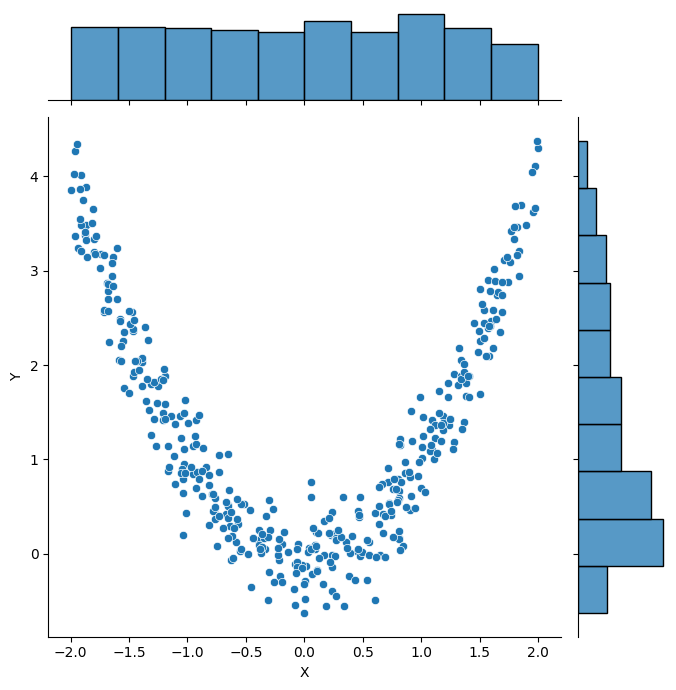

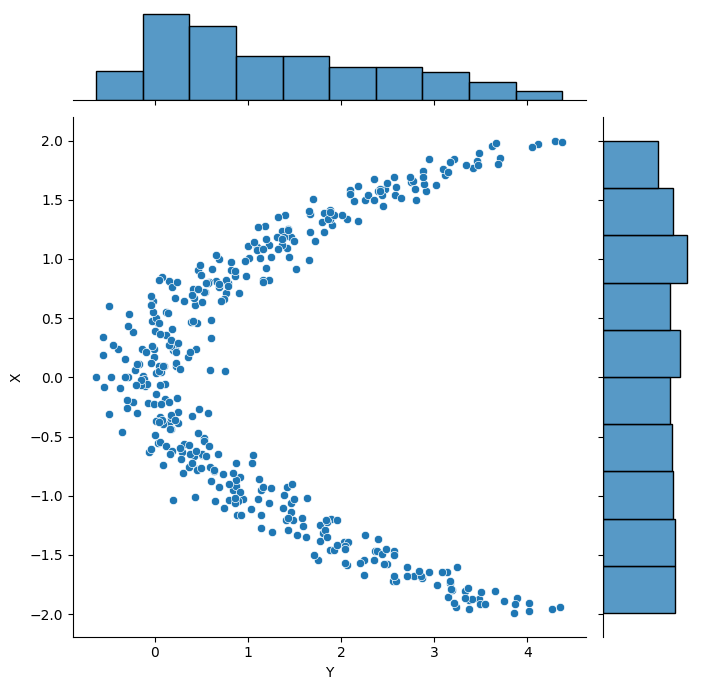

In [4]:
sns.jointplot(dataframe, x="X", y="Y", height=7)
plt.show()
sns.jointplot(dataframe, x="Y", y="X", height=7)
plt.show()

We compute the ANM fitness score on both directions. **The lower the score, the more likely the direction is correct.**

In [5]:
anm = ANM()
x_to_y = anm.anm_score(X.reshape(-1, 1), Y)
y_to_x = anm.anm_score(Y.reshape(-1, 1), X)

In [6]:
x_to_y, y_to_x, y_to_x - x_to_y

(0.12991088312594, 7.288902191760396, 7.158991308634456)

We can see that the the X to Y score is way lower than the Y to X score, which means that the ANM is more confident that X causes Y than the other way around.

To get a nice, one value result, we can substract one direction from the other. If the result is positive, it means that X causes Y, and if it is negative, it means that Y causes X.

Let's now generate a sample submission using the sample data set.

>Note : ANM is a method that does not require training, so we are not using the training set here.

>Note : The sample_submission set is a subset of the validation set. It is the first 100 pairs from the X_valid.csv file. It is provided to help you quickly run the notebook, but wont work on Codabench as you need to submit predictions for the full validation set. You should change the path to the validation set if you want to generate a working submission. The full datasets can be downloaded from the Files tab on the Codabench challenge page.

In [25]:
# sample data is the first 100 pairs from the X_valid.csv file
data_dir = 'sample_data/'
data_file = 'X_sample.csv'
output_dir = 'sample_submission_sample_data/'
output_zip = 'sample_submission_sample_data.zip'

# ============================================================

# UNCOMMENT TO LOAD THE FULL VALIDATION SET FROM PUBLIC_DATA
# To download public data : https://www.codabench.org/datasets/download/aafd38ea-cb96-47b6-be2e-e0fbacbb2bcb/

# data_dir = 'public_data/valid_set/'
# data_file = 'X_valid.csv'
# output_dir = 'sample_submission_full_set/'
# output_zip = 'sample_submission_full_set.zip'

# ============================================================


data_path = data_dir + data_file

In [8]:
# Load the validation data
data = pd.read_csv(data_path, index_col=0)
data

,A,B
SampleID,,
valid1,19226 7619 -2173 5413 6894 3269 -19328 -15435...,187 3407 4666 -3868 7323 -4112 8857 -530 -809...
valid2,-10169 605 5991 -10169 -10169 11379 5991 -101...,-25205 5062 -5027 -5027 5062 -2505 2540 15151...
valid3,3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 4 3 3 2 2 4 3...,1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1...
valid4,0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0...,0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1...
valid5,-9425 -9512 -8549 -6246 -3769 -1905 -8078 252...,1 10 7 1 11 14 14 10 10 9 11 1 14 10 1 8 2 14...
...,...,...
valid96,-1762 4980 -20304 -77 -10190 3294 1609 8351 1...,13712 8583 -17023 9227 1328 17183 13600 -3578...
valid97,2608 -27376 5945 12199 8081 -3099 9092 7986 7...,-5958 8248 32346 -5950 17478 -5992 -6158 -172...
valid98,930 579 23115 -5151 -5855 -189 976 -5356 422 ...,-11282 1022 11885 3219 3384 -18901 6926 1174 ...


The data is a list of pairs. Right now the data points are stored as strings, so we need to convert them to a list of numbers.

In [9]:
convert = lambda x: np.array([float(i) for i in x.split(' ')[1:]])
data["A"] = data["A"].apply(convert)
data["B"] = data["B"].apply(convert)
data

,A,B
SampleID,,
valid1,"[19226.0, 7619.0, -2173.0, 5413.0, 6894.0, 326...","[187.0, 3407.0, 4666.0, -3868.0, 7323.0, -4112..."
valid2,"[-10169.0, 605.0, 5991.0, -10169.0, -10169.0, ...","[-25205.0, 5062.0, -5027.0, -5027.0, 5062.0, -..."
valid3,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
valid4,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
valid5,"[-9425.0, -9512.0, -8549.0, -6246.0, -3769.0, ...","[1.0, 10.0, 7.0, 1.0, 11.0, 14.0, 14.0, 10.0, ..."
...,...,...
valid96,"[-1762.0, 4980.0, -20304.0, -77.0, -10190.0, 3...","[13712.0, 8583.0, -17023.0, 9227.0, 1328.0, 17..."
valid97,"[2608.0, -27376.0, 5945.0, 12199.0, 8081.0, -3...","[-5958.0, 8248.0, 32346.0, -5950.0, 17478.0, -..."
valid98,"[930.0, 579.0, 23115.0, -5151.0, -5855.0, -189...","[-11282.0, 1022.0, 11885.0, 3219.0, 3384.0, -1..."


Here, we plot some causal pairs. Some scatterplots look weird, because some pairs contain categorical variables. The types are detailed in the `X_valid_info.csv` file.

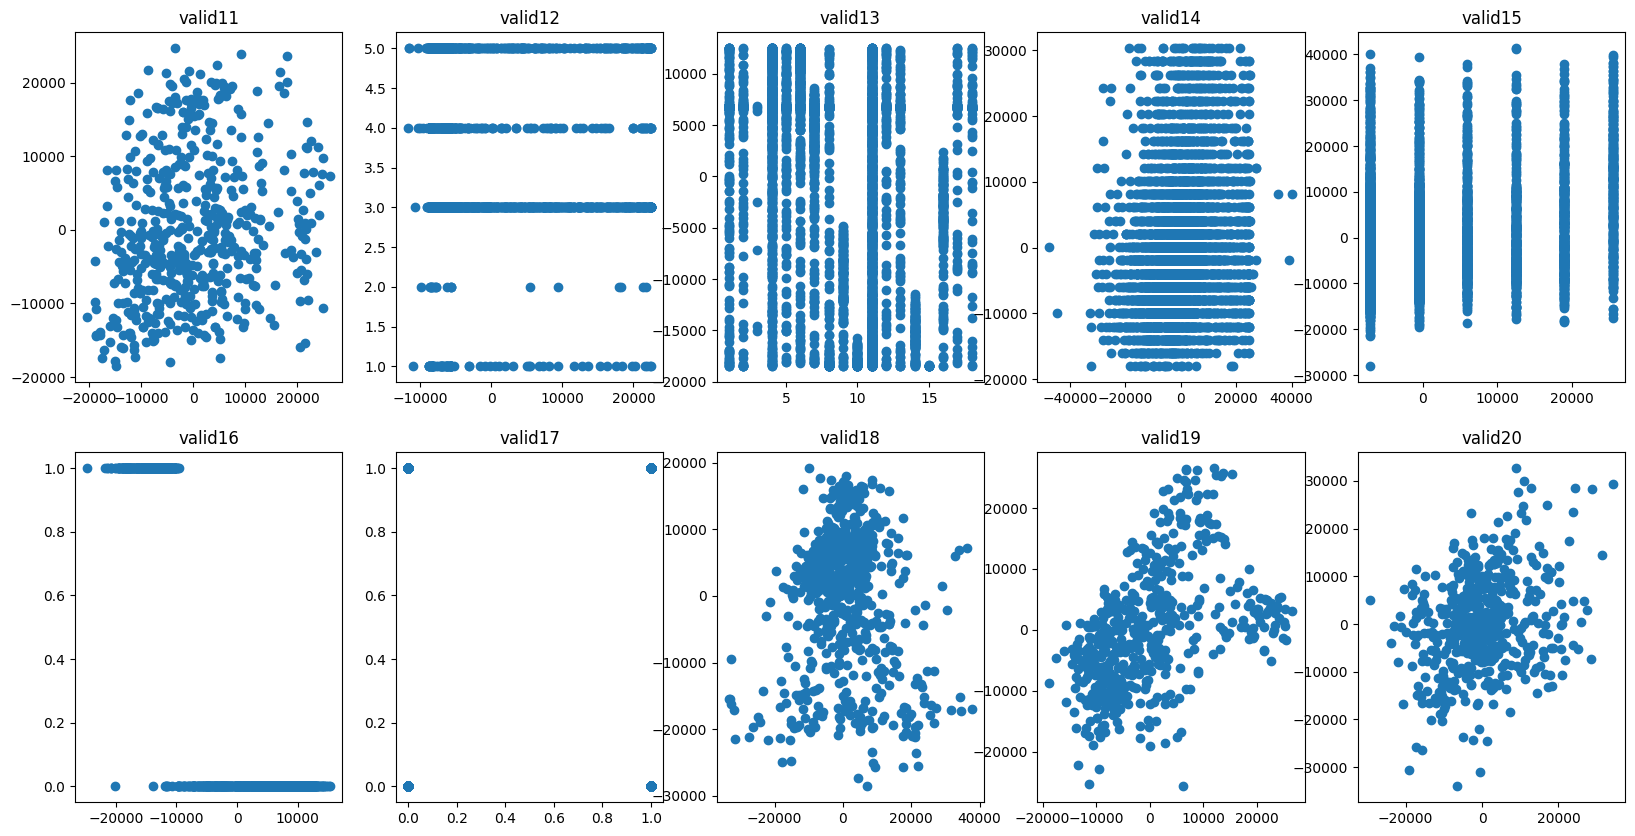

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axs[i // 5, i % 5].scatter(data["A"][i+10], data["B"][i+10])
    axs[i // 5, i % 5].set_title(data.index[i+10])
plt.show()

In [11]:
data.A.apply(len).describe()

count     100.000000
mean     2222.900000
std      1929.874092
min       158.000000
25%       607.250000
50%      1501.000000
75%      3250.750000
max      7758.000000
Name: A, dtype: float64

Some of these pairs have a massive ammount of points.

We are going to downsample those have have more than 600 points, down to 600 points. We might lose information, but it will make the computation of the ANM faster. Computing the ANM without downsampling on the **full** validation set would take hours, but with downsampling it took about 15 minutes on Google Colab.

In [12]:
data_downsampled = data.copy()

In [13]:
def downsample_row(row):
  if len(row.A) > 600:
    indices = np.random.choice(len(row.A), size=600, replace=False)
    rowcopy = row.copy()
    rowcopy.A = rowcopy.A[indices]
    rowcopy.B = rowcopy.B[indices]
    return rowcopy
  return row

In [14]:
data_downsampled = data_downsampled.progress_apply(downsample_row, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
data_downsampled.A.apply(len).describe()

count    100.000000
mean     573.690000
std       68.260004
min      158.000000
25%      596.750000
50%      600.000000
75%      600.000000
max      600.000000
Name: A, dtype: float64

We now have a a mean number of points per pair of ~580.

Let's compute the ANM on the downsampled set.

In [16]:
anm = ANM()

In [17]:
def score_pair(row):
    a_to_b = anm.anm_score(row["A"].reshape(-1, 1), row["B"])
    b_to_a = anm.anm_score(row["B"].reshape(-1, 1), row["A"])
    return b_to_a - a_to_b

In [18]:
# apply score_pair to each row of the dataframe
res = data_downsampled.progress_apply(score_pair, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
res

SampleID
valid1      0.263518
valid2      0.307015
valid3     -0.001430
valid4      0.000185
valid5     -0.703035
              ...   
valid96     1.981114
valid97    -0.148349
valid98     0.041328
valid99    -0.000307
valid100    2.850336
Length: 100, dtype: float64

We save the results in a csv file, and zip it.

**CodaBench expects a file named `results.csv` in the root of the zip file.**

**You might need to change the zip command depending on your OS.**

In [20]:
res.rename("Target").to_csv(output_dir + "results.csv", header=True)

In [24]:
# zip the results.csv file, such that the results.csv file is at the root of the zip file

# THIS COMMAND PROBABLY DOES NOT WORK ON WINDOWS
!cd $output_dir && zip $output_zip results.csv

# move the zip to the root of the starting kit
!mv $output_dir$output_zip .

updating: results.csv (deflated 54%)


If using the full validation set instead of the sample data, the submission.zip is ready to be submitted on Codabench.